# 1. Imports

In [1]:
from impt_functions import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd 
import numpy as np
from fairlearn.reductions import ExponentiatedGradient, GridSearch, DemographicParity, EqualizedOdds, \
    TruePositiveRateParity, FalsePositiveRateParity, ErrorRateParity, BoundedGroupLoss
from fairlearn.metrics import *
from raiwidgets import FairnessDashboard
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
%matplotlib inline

# 2. Prepare data

In [2]:
data = get_data('/home/mackenzie/git_repositories/delayedimpact/data/simData_oom10.csv')

      score  repay_probability  race  repay_indices
0       610              78.90     1              1
1       568              47.77     0              0
2       750              98.13     1              1
3       775              98.45     1              1
4       704              95.88     1              1
...     ...                ...   ...            ...
9995    832              98.99     1              1
9996    416              10.91     1              0
9997    444              14.63     1              0
9998    778              98.47     1              1
9999    738              97.68     1              1

[10000 rows x 4 columns]


In [3]:
X_train, X_test, y_train, y_test, race_train, race_test, sample_weight_train, sample_weight_test = prep_data(data=data, test_size=0.3, weight_index=1)

Here are the x values:  [[610   1]
 [568   0]
 [750   1]
 ...
 [444   1]
 [778   1]
 [738   1]] 

Here are the y values:  [1 0 1 ... 0 1 1]
Sample weights are all equal.


# Decision Tree Classifier

## Train DTC classifier + Collect Predictions
NOTE: atm sample_weight are all 1s

In [4]:
# Reference: https://www.datacamp.com/community/tutorials/decision-tree-classification-python

# Initialize classifier:
clf = DecisionTreeClassifier()

# Train the classifier:
model = clf.fit(X_train,y_train)

# Make predictions with the classifier:
y_predict = model.predict(X_test)

# Scores on test set
test_scores = model.predict_proba(X_test)[:, 1]

### Evaluation of classifier overall

In [5]:
# Metrics
models_dict = {"Unmitigated": (y_predict, test_scores)}
get_metrics_df(models_dict, y_test, race_test)

,Unmitigated
Overall selection rate,0.722667
Demographic parity difference,0.507649
Demographic parity ratio,0.352005
------,
Overall balanced error rate,0.142254
Balanced error rate difference,0.087377
------,
False positive rate difference,0.158826
False negative rate difference,0.33358
Equalized odds difference,0.33358


In [6]:
cm = confusion_matrix(y_test, y_predict)
print(cm)
print(classification_report(y_test, y_predict)) 
evaluation_outcome_rates(y_test, y_predict, sample_weight_test)

[[ 671  178]
 [ 161 1990]]
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       849
           1       0.92      0.93      0.92      2151

    accuracy                           0.89      3000
   macro avg       0.86      0.86      0.86      3000
weighted avg       0.89      0.89      0.89      3000

FNER=FN/(FN+TP)=  0.07484890748489074
FPER=FP/(FP+TN)=  0.20965842167255594
TNR=TN/(TN+FP)=  0.790341578327444
TPR=TP/(FP+FN)=  0.9251510925151093


### Evaluation of classifier by race

In [7]:
evaluation_by_race(X_test, y_test, race_test, y_predict, sample_weight_test)

EVALUATION FOR BLACK GROUP
[[211  22]
 [ 49  77]]
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       233
           1       0.78      0.61      0.68       126

    accuracy                           0.80       359
   macro avg       0.79      0.76      0.77       359
weighted avg       0.80      0.80      0.80       359

FNER=FN/(FN+TP)=  0.3888888888888889
FPER=FP/(FP+TN)=  0.0944206008583691
TNR=TN/(TN+FP)=  0.9055793991416309
TPR=TP/(FP+FN)=  0.6111111111111112

EVALUATION FOR WHITE GROUP
[[ 460  156]
 [ 112 1913]]
              precision    recall  f1-score   support

           0       0.80      0.75      0.77       616
           1       0.92      0.94      0.93      2025

    accuracy                           0.90      2641
   macro avg       0.86      0.85      0.85      2641
weighted avg       0.90      0.90      0.90      2641

FNER=FN/(FN+TP)=  0.055308641975308645
FPER=FP/(FP+TN)=  0.2532467532467532
TNR=TN/(TN+FP)=  0.

### Delayed impact calculated by race

In [8]:
calculate_delayed_impact(X_test, y_test, y_predict, race_test)

The delayed impact of the black group is:  6.894150417827298
The delayed impact of the white group is:  45.465732677016284


### Fairness Metric Evaluation of classifier

In [9]:
print_fairness_metrics(y_test, y_predict, race_test)

Selection Rate Overall:  0.7226666666666667
Selection Rate By Group:  sensitive_feature_0
0    0.275766
1    0.783415
Name: selection_rate, dtype: object 

DP Difference:  0.5076493562516942
-->difference of 0 means that all groups have the same selection rate
DP Ratio: 0.3520048574863585
-->ratio of 1 means that all groups have the same selection rate 

EOD Difference:  0.33358024691358024
-->difference of 0 means that all groups have the same TN, TN, FP, and FN rates
EOD Ratio: 0.37284032133817546
-->ratio of 1 means that all groups have the same TN, TN, FP, and FN rates rates 



The positional argument 'metric' has been replaced by a keyword argument 'metrics'. From version 0.10.0 passing it as a positional argument or as a keyword argument 'metric' will result in an error


## Exponentiated Gradient Reduction Alg for Adding Fairness Constraints

### Demographic Parity

In [10]:
eg_dp = add_contraint(model, 'DP', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, False)

Exponentiated Gradient Reduction Alg is used here with  DP  as the fairness constraint.

Evaluation of  DP -constrained classifier overall:
[[ 543  306]
 [ 130 2021]]
              precision    recall  f1-score   support

           0       0.81      0.64      0.71       849
           1       0.87      0.94      0.90      2151

    accuracy                           0.85      3000
   macro avg       0.84      0.79      0.81      3000
weighted avg       0.85      0.85      0.85      3000

FNER=FN/(FN+TP)=  0.06043700604370061
FPER=FP/(FP+TN)=  0.36042402826855124
TNR=TN/(TN+FP)=  0.6395759717314488
TPR=TP/(FP+FN)=  0.9395629939562994


Evaluation of  DP -constrained classifier by race:
EVALUATION FOR BLACK GROUP
[[ 71 162]
 [  7 119]]
              precision    recall  f1-score   support

           0       0.91      0.30      0.46       233
           1       0.42      0.94      0.58       126

    accuracy                           0.53       359
   macro avg       0.67      0.62    

The positional argument 'metric' has been replaced by a keyword argument 'metrics'. From version 0.10.0 passing it as a positional argument or as a keyword argument 'metric' will result in an error


### Equalized Odds

In [11]:
eg_eo = add_contraint(model, 'EO', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, False)

Exponentiated Gradient Reduction Alg is used here with  EO  as the fairness constraint.

Evaluation of  EO -constrained classifier overall:
[[ 621  228]
 [ 165 1986]]
              precision    recall  f1-score   support

           0       0.79      0.73      0.76       849
           1       0.90      0.92      0.91      2151

    accuracy                           0.87      3000
   macro avg       0.84      0.83      0.83      3000
weighted avg       0.87      0.87      0.87      3000

FNER=FN/(FN+TP)=  0.07670850767085077
FPER=FP/(FP+TN)=  0.26855123674911663
TNR=TN/(TN+FP)=  0.7314487632508834
TPR=TP/(FP+FN)=  0.9232914923291492


Evaluation of  EO -constrained classifier by race:
EVALUATION FOR BLACK GROUP
[[153  80]
 [ 22 104]]
              precision    recall  f1-score   support

           0       0.87      0.66      0.75       233
           1       0.57      0.83      0.67       126

    accuracy                           0.72       359
   macro avg       0.72      0.74    

The positional argument 'metric' has been replaced by a keyword argument 'metrics'. From version 0.10.0 passing it as a positional argument or as a keyword argument 'metric' will result in an error


### True Positive Rate Parity

In [12]:
eg_tprp = add_contraint(model, 'TPRP', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, False)

Exponentiated Gradient Reduction Alg is used here with  TPRP  as the fairness constraint.

Evaluation of  TPRP -constrained classifier overall:
[[ 621  228]
 [ 148 2003]]
              precision    recall  f1-score   support

           0       0.81      0.73      0.77       849
           1       0.90      0.93      0.91      2151

    accuracy                           0.87      3000
   macro avg       0.85      0.83      0.84      3000
weighted avg       0.87      0.87      0.87      3000

FNER=FN/(FN+TP)=  0.06880520688052069
FPER=FP/(FP+TN)=  0.26855123674911663
TNR=TN/(TN+FP)=  0.7314487632508834
TPR=TP/(FP+FN)=  0.9311947931194793


Evaluation of  TPRP -constrained classifier by race:
EVALUATION FOR BLACK GROUP
[[146  87]
 [ 19 107]]
              precision    recall  f1-score   support

           0       0.88      0.63      0.73       233
           1       0.55      0.85      0.67       126

    accuracy                           0.70       359
   macro avg       0.72      0.

The positional argument 'metric' has been replaced by a keyword argument 'metrics'. From version 0.10.0 passing it as a positional argument or as a keyword argument 'metric' will result in an error


### False Positive Rate Parity

In [13]:
eg_fprp = add_contraint(model, 'FPRP', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, False)

Exponentiated Gradient Reduction Alg is used here with  FPRP  as the fairness constraint.

Evaluation of  FPRP -constrained classifier overall:
[[ 635  214]
 [ 147 2004]]
              precision    recall  f1-score   support

           0       0.81      0.75      0.78       849
           1       0.90      0.93      0.92      2151

    accuracy                           0.88      3000
   macro avg       0.86      0.84      0.85      3000
weighted avg       0.88      0.88      0.88      3000

FNER=FN/(FN+TP)=  0.06834030683403068
FPER=FP/(FP+TN)=  0.25206124852767964
TNR=TN/(TN+FP)=  0.7479387514723204
TPR=TP/(FP+FN)=  0.9316596931659693


Evaluation of  FPRP -constrained classifier by race:
EVALUATION FOR BLACK GROUP
[[163  70]
 [ 24 102]]
              precision    recall  f1-score   support

           0       0.87      0.70      0.78       233
           1       0.59      0.81      0.68       126

    accuracy                           0.74       359
   macro avg       0.73      0.

The positional argument 'metric' has been replaced by a keyword argument 'metrics'. From version 0.10.0 passing it as a positional argument or as a keyword argument 'metric' will result in an error


### Error Rate Parity

In [14]:
eg_erp = add_contraint(model, 'ERP', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, False)

Exponentiated Gradient Reduction Alg is used here with  ERP  as the fairness constraint.

Evaluation of  ERP -constrained classifier overall:
[[ 661  188]
 [ 191 1960]]
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       849
           1       0.91      0.91      0.91      2151

    accuracy                           0.87      3000
   macro avg       0.84      0.84      0.84      3000
weighted avg       0.87      0.87      0.87      3000

FNER=FN/(FN+TP)=  0.08879590887959089
FPER=FP/(FP+TN)=  0.22143698468786807
TNR=TN/(TN+FP)=  0.7785630153121319
TPR=TP/(FP+FN)=  0.9112040911204091


Evaluation of  ERP -constrained classifier by race:
EVALUATION FOR BLACK GROUP
[[211  22]
 [ 49  77]]
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       233
           1       0.78      0.61      0.68       126

    accuracy                           0.80       359
   macro avg       0.79      0.76 

The positional argument 'metric' has been replaced by a keyword argument 'metrics'. From version 0.10.0 passing it as a positional argument or as a keyword argument 'metric' will result in an error


### Bounded Group Loss (TODO: issue, need to figure out loss parameter)

In [15]:
#add_contraint(model, 'BGL', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, False)

## Grid Search Reduction Alg for Adding Fairness Constraints

### Demographic Parity

In [16]:
gs_dp = add_contraint(model, 'DP', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, False)

Grid Search Reduction Alg is used here with  DP  as the fairness constraint.

Evaluation of  DP -constrained classifier overall:
[[ 581  268]
 [ 135 2016]]
              precision    recall  f1-score   support

           0       0.81      0.68      0.74       849
           1       0.88      0.94      0.91      2151

    accuracy                           0.87      3000
   macro avg       0.85      0.81      0.83      3000
weighted avg       0.86      0.87      0.86      3000

FNER=FN/(FN+TP)=  0.06276150627615062
FPER=FP/(FP+TN)=  0.31566548881036516
TNR=TN/(TN+FP)=  0.6843345111896348
TPR=TP/(FP+FN)=  0.9372384937238494


Evaluation of  DP -constrained classifier by race:
EVALUATION FOR BLACK GROUP
[[109 124]
 [ 12 114]]
              precision    recall  f1-score   support

           0       0.90      0.47      0.62       233
           1       0.48      0.90      0.63       126

    accuracy                           0.62       359
   macro avg       0.69      0.69      0.62     

The positional argument 'metric' has been replaced by a keyword argument 'metrics'. From version 0.10.0 passing it as a positional argument or as a keyword argument 'metric' will result in an error


In [17]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = gs_dp.lambda_vecs_
print(lambda_vecs[0])

sign  event  group_id
+     all    0           0.0
             1           0.0
-     all    0           0.0
             1           2.0
Name: 0, dtype: float64


The next few cells come from: https://github.com/fairlearn/fairlearn/blob/main/notebooks/Binary%20Classification%20with%20the%20UCI%20Credit-card%20Default%20Dataset.ipynb

Note: we train multiple models corresponding to different trade-off points between the performance metric (balanced accuracy) and fairness metric.

{'Unmitigated': (array([1, 1, 1, ..., 0, 1, 1]), array([0.82142857, 1.        , 1.        , ..., 0.09090909, 0.53333333,
       1.        ]))}


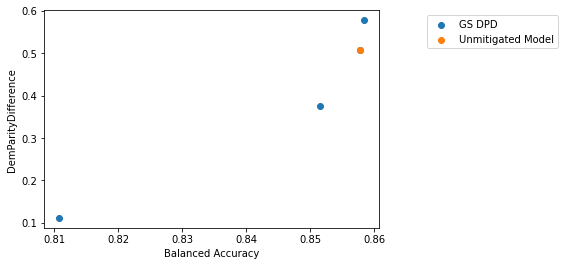

GS DPD
                               Unmitigated     GS DPD
Overall selection rate            0.722667   0.761333
Demographic parity difference     0.507649   0.111754
Demographic parity ratio          0.352005   0.855747
------                                               
Overall balanced error rate       0.142254   0.189213
Balanced error rate difference    0.087377    0.16646
 ------                                              
False positive rate difference    0.158826   0.298423
False negative rate difference     0.33358  0.0344974
Equalized odds difference          0.33358   0.298423
  ------                                             
Overall AUC                       0.937583   0.923972
AUC difference                    0.100627   0.102742


In [18]:
grid_search_show(gs_dp, demographic_parity_difference, y_predict, X_test, y_test, race_test, 'DemParityDifference','GS DPD', models_dict, 0.3)

In [19]:
models_dict.pop('GS DPD')
models_dict

{'Unmitigated': (array([1, 1, 1, ..., 0, 1, 1]),
  array([0.82142857, 1.        , 1.        , ..., 0.09090909, 0.53333333,
         1.        ]))}

### Equalized Odds Used

In [21]:
gs_eo = add_contraint(model, 'EO', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, False)

Grid Search Reduction Alg is used here with  EO  as the fairness constraint.

Evaluation of  EO -constrained classifier overall:
[[ 640  209]
 [ 147 2004]]
              precision    recall  f1-score   support

           0       0.81      0.75      0.78       849
           1       0.91      0.93      0.92      2151

    accuracy                           0.88      3000
   macro avg       0.86      0.84      0.85      3000
weighted avg       0.88      0.88      0.88      3000

FNER=FN/(FN+TP)=  0.06834030683403068
FPER=FP/(FP+TN)=  0.24617196702002356
TNR=TN/(TN+FP)=  0.7538280329799765
TPR=TP/(FP+FN)=  0.9316596931659693


Evaluation of  EO -constrained classifier by race:
EVALUATION FOR BLACK GROUP
[[168  65]
 [ 24 102]]
              precision    recall  f1-score   support

           0       0.88      0.72      0.79       233
           1       0.61      0.81      0.70       126

    accuracy                           0.75       359
   macro avg       0.74      0.77      0.74     

The positional argument 'metric' has been replaced by a keyword argument 'metrics'. From version 0.10.0 passing it as a positional argument or as a keyword argument 'metric' will result in an error


In [23]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = gs_eo.lambda_vecs_
print(lambda_vecs[0])

sign  event    group_id
+     label=0  0           0.0
               1           0.0
      label=1  0           0.0
               1           0.0
-     label=0  0           0.0
               1           2.0
      label=1  0           0.0
               1           0.0
Name: 0, dtype: float64


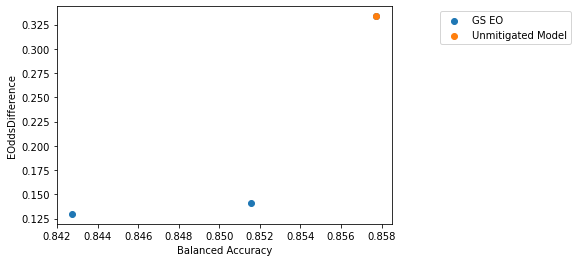

GS EO
                               Unmitigated      GS EO
Overall selection rate            0.722667   0.737667
Demographic parity difference     0.507649   0.309525
Demographic parity ratio          0.352005   0.600461
------                                               
Overall balanced error rate       0.142254   0.157256
Balanced error rate difference    0.087377  0.0874696
 ------                                              
False positive rate difference    0.158826  0.0452037
False negative rate difference     0.33358   0.129735
Equalized odds difference          0.33358   0.129735
  ------                                             
Overall AUC                       0.937583   0.932551
AUC difference                    0.100627   0.101383


In [25]:
grid_search_show(gs_eo, equalized_odds_difference, y_predict, X_test, y_test, race_test, 'EOddsDifference','GS EO', models_dict, 0.3)

In [ ]:
models_dict.pop('GS EO')
models_dict

### True Positive Rate Parity

In [ ]:
gs_tprp = add_contraint(model, 'TPRP', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, False)

In [ ]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = gs_tprp.lambda_vecs_
print(lambda_vecs[0])

### False Positive Rate Parity

In [ ]:
gs_fprp = add_contraint(model, 'FPRP', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, False)

In [ ]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = gs_fprp.lambda_vecs_
print(lambda_vecs[0])

### Error Rate Parity

In [ ]:
gs_erp = add_contraint(model, 'ERP', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, False)

In [ ]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = gs_erp.lambda_vecs_
print(lambda_vecs[0])

### Bounded Group Loss (issue, need to figure out loss parameter)

In [ ]:
#gs_bgl = add_contraint(model, 'BGL', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, False)

In [ ]:
# We can examine the values of lambda_i chosen for us:
#lambda_vecs = gs_dp.lambda_vecs_
#print(lambda_vecs[0])